In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from functools import partial
from scipy.optimize import bisect, brentq, newton
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, TheilSenRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

1. Исходные данные

In [2]:
# Значения предикторов для прогноза целевой переменной
A_max = (1800, 1500, 1800, 2000, 1500)

# Отн. погрешности измерений значений элементов матрицы A_h и вектора b_d
k_A = 0.0
k_b = 0.0

# Отн. размер тестовой выборки
test_size = 0.3

2. Загрузка датасетов

In [3]:
# Загрузка точных коэффициентов регрессии (для контроля обучения моделей)
z_acc = pd.read_excel('C:\Datasets/dataset_z_acc.xlsx')

In [4]:
df = pd.read_excel('C:\Datasets/dataset_0.xlsx')
df.round(2)

,A_1,A_2,A_3,A_4,A_5,b
0,400.00,200.00,450.00,600.00,200.00,51.70
1,400.29,200.27,450.44,600.81,200.22,51.75
2,400.79,200.52,451.00,601.67,200.33,51.82
3,401.09,200.62,451.42,602.55,200.36,51.86
4,401.54,200.71,451.62,603.23,200.36,51.91
...,...,...,...,...,...,...
995,842.60,419.45,961.85,1254.55,424.56,109.12
996,843.05,419.61,962.19,1254.92,424.85,109.17
997,843.41,419.90,962.81,1256.36,424.93,109.24
998,844.53,420.52,963.68,1257.61,425.02,109.36


3. Попарные графики рассеяния

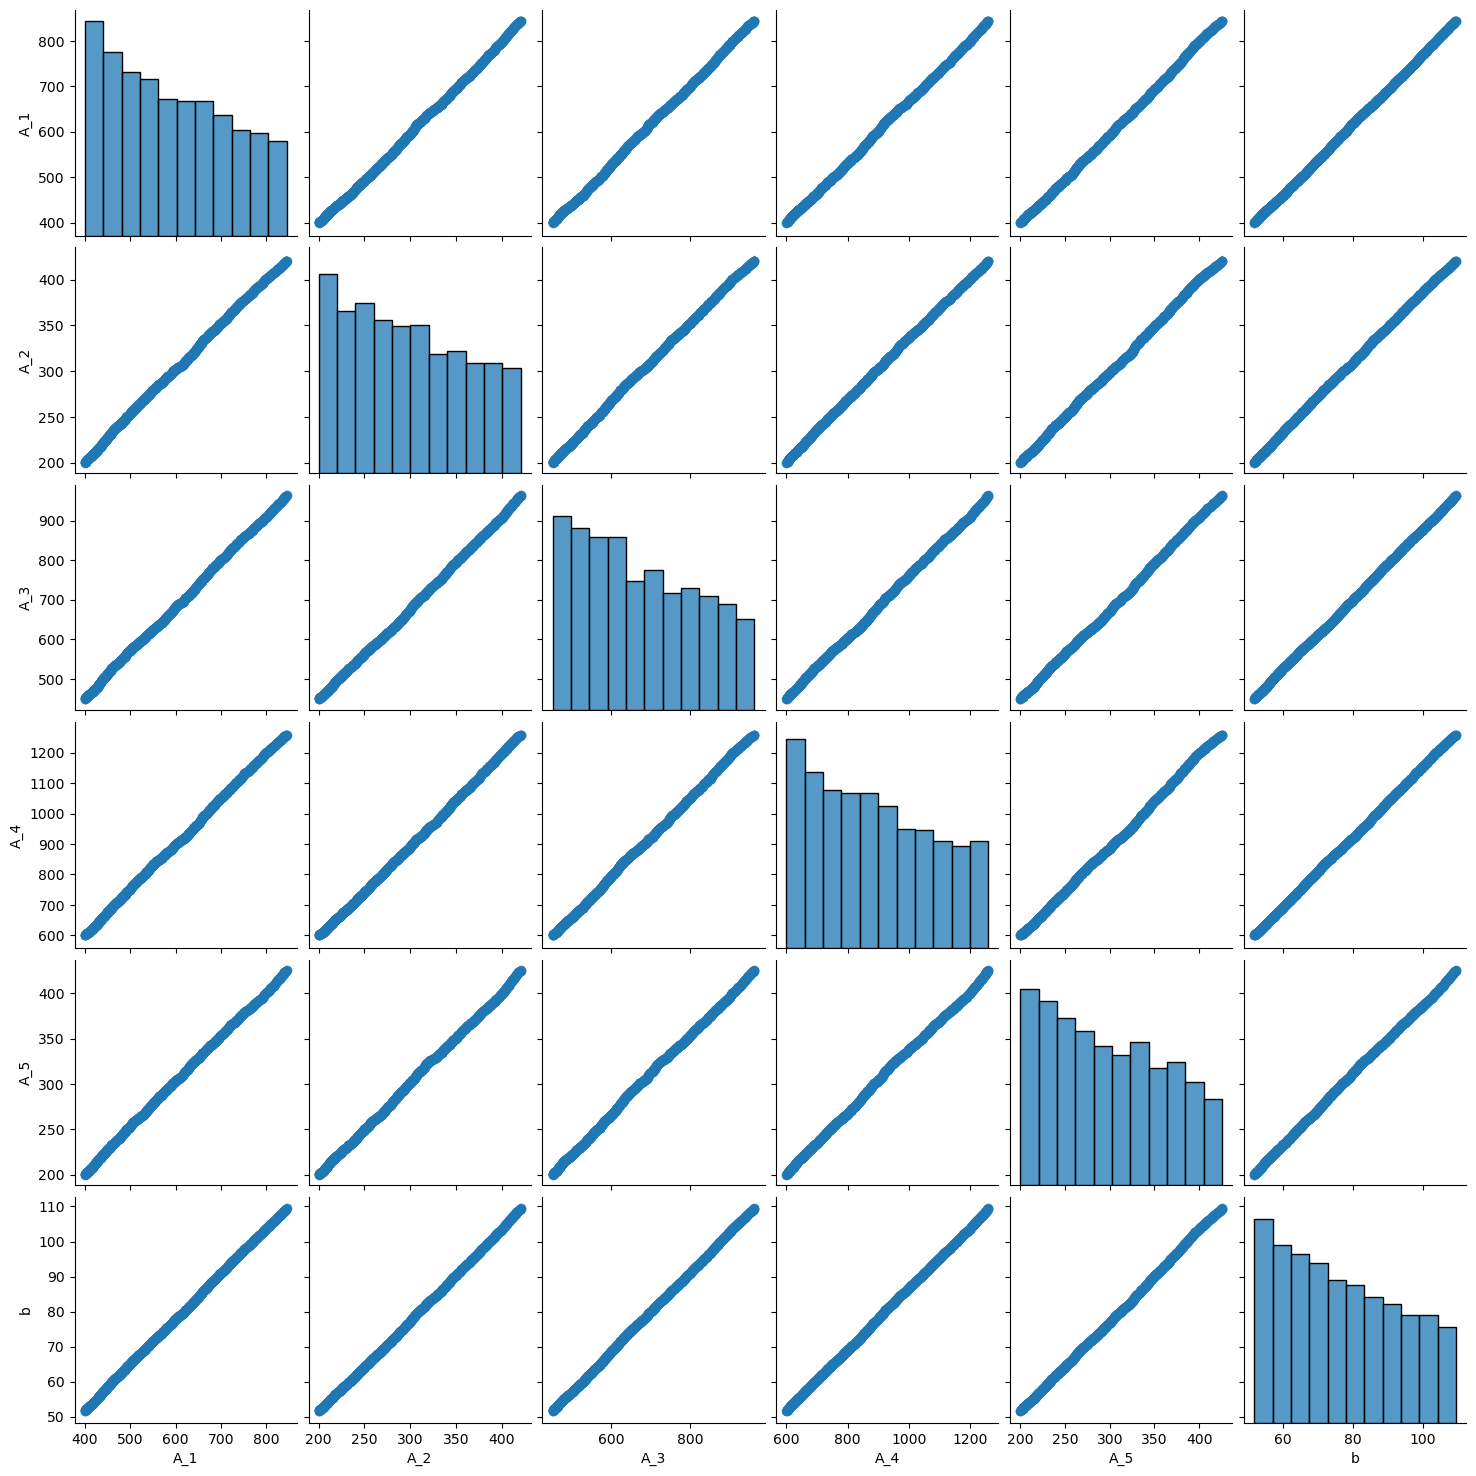

In [5]:
sns.pairplot(df, kind="reg")
plt.show()

4. Выделение X и y из df

In [6]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values                                         

5. Масштабирование признаков и вектора A_max

In [7]:
sc = MaxAbsScaler() # MaxAbsScaler()    MinMaxScaler()    RobustScaler()    StandardScaler()
X_std = sc.fit_transform(X)

In [8]:
A_max_std = sc.transform([A_max])
A_max_std.round(3)

array([[2.13 , 3.566, 1.866, 1.589, 3.524]])

6. Обучение моделей регрессоров

In [9]:
metrics = {}

In [10]:
lr = LinearRegression()
model_lr = lr.fit(X_std, y)

y_pred = model_lr.predict(X_std)
rmse_lr = np.sqrt(mean_squared_error(y, y_pred)).round(3)
mae_lr = mean_absolute_error(y, y_pred).round(3)
r2_lr = r2_score(y, y_pred).round(3)
b_max_lr = model_lr.predict(A_max_std)[0].round(3)
metrics['LinRegr'] = (r2_lr, b_max_lr)

print(f'RMSE train: {rmse_lr}')
print()
print(f'MAE train:  {mae_lr}')
print()
print(f'R2 train:   {r2_lr}')
print()
print(f'b max: {b_max_lr}')
print()
print('Коэффициенты регрессии:')
print(pd.DataFrame(model_lr.coef_[:], columns=['k']).round(3))
print(f'Свободный член регрессии  a0 =  {model_lr.intercept_.round(3)}')

RMSE train: 0.0

MAE train:  0.0

R2 train:   1.0

b max: 242.5

Коэффициенты регрессии:
        k
0  33.803
1  14.721
2  28.941
3  25.178
4   6.810
Свободный член регрессии  a0 =  -0.0


In [11]:
rid = Ridge()
rid_parameters = {'alpha': np.logspace(-15, 5, num=51), 
                 'random_state':[1, 7, 42, 100]
}
model_rid = GridSearchCV(estimator=rid,
                   param_grid=rid_parameters,
                   scoring='r2', # 'neg_mean_absolute_error'
                   n_jobs=-1,
                   cv=5)
model_rid.fit(X_std, y)

y_rid_pred = model_rid.predict(X_std)
rmse_rid = np.sqrt(mean_squared_error(y, y_rid_pred)).round(3)
mae_rid = mean_absolute_error(y, y_rid_pred).round(3)
r2_rid = r2_score(y, y_rid_pred).round(3)
b_max_rid = model_rid.predict(A_max_std)[0].round(3)
metrics['Ridge'] = (r2_rid, b_max_rid)

print(f'RMSE train: {rmse_rid}')
print()
print(f'MAE train:  {mae_rid}')
print()
print(f'R2 train:   {r2_rid}')
print()
print(f'b max: {b_max_rid}')
model_rid.best_params_

RMSE train: 0.0

MAE train:  0.0

R2 train:   1.0

b max: 242.5


{'alpha': 1e-15, 'random_state': 1}

In [12]:
tsr = TheilSenRegressor()
tsr_parameters = {
    'random_state':[1, 7, 42, 100]
}
model_tsr = GridSearchCV(estimator=tsr,
                   param_grid=tsr_parameters,
                   scoring='r2', # 'neg_mean_absolute_error'
                   n_jobs=-1,
                   cv=5)
model_tsr.fit(X_std, y)

y_tsr_pred = model_tsr.predict(X_std)
rmse_tsr = np.sqrt(mean_squared_error(y, y_tsr_pred)).round(3)
mae_tsr = mean_absolute_error(y, y_tsr_pred).round(3)
r2_tsr = r2_score(y, y_tsr_pred).round(3)
b_max_tsr = model_tsr.predict(A_max_std)[0].round(3)
metrics['TheilSen'] = (r2_tsr, b_max_tsr)

print(f'RMSE train: {rmse_tsr}')
print()
print(f'MAE train:  {mae_tsr}')
print()
print(f'R2 train:   {r2_tsr}')
print()
print(f'b max: {b_max_tsr}')
model_tsr.best_params_

RMSE train: 0.0

MAE train:  0.0

R2 train:   1.0

b max: 242.5


{'random_state': 1}

7. Средние значения метрик регрессоров и целевой переменной b

In [13]:
r2_values = [metrics[key][-2] for key in metrics]
r2_mean = sum(r2_values) / len(r2_values)
b_max_values = [metrics[key][-1] for key in metrics]
b_max_mean = sum(b_max_values) / len(b_max_values)
metrics['Mean'] = (r2_mean.round(3), b_max_mean.round(3))

print(f'b_mean: {b_max_mean.round(3)}')

b_mean: 242.5


8. Определение коэффициента регуляризации alpha методом обобщенной невязки

In [14]:
# Функция вычисления обобщенной невязки delta_residual
def calculate_delta_residual(alpha, X, y, h, d):
    z = np.linalg.inv(X.T @ X + alpha * np.eye(X.shape[1])) @ X.T @ y
    residual = np.linalg.norm(X @ z - y)
    norm = np.linalg.norm(z)
    delta_residual = residual**2 - (h * norm + d)**2

    return delta_residual

X_h = X_std
y_d = y
# Вычисление точности задания матрицы A: h = ||A - A_h|| и вектора b: d = ||b - b_d||
h = k_A * np.linalg.norm(X_h)
d = k_b * np.linalg.norm(y_d)

# Поиск коэффициента регуляризации alpha
calculate_delta_residual_partial = partial(calculate_delta_residual, X=X_h, y=y_d, h=h, d=d)
alpha = newton(calculate_delta_residual_partial, x0=1e-7, tol=1e-7)
# alpha = bisect(calculate_delta_residual_partial, 1e-7, 1e5)
# alpha = brentq(calculate_delta_residual_partial, a=1e-7, b=1e5, xtol=1e-5)

print(f"Коэффициент регуляризации alpha = {alpha:.{2}e}")

Коэффициент регуляризации alpha = 9.98e-08


9. Регуляризированное решение системы уравнений

In [15]:
# Регуляризованное решение
z_hd = np.linalg.inv(X_h.T @ X_h + alpha * np.eye(X_h.shape[1])) @ X_h.T @ y_d

y_reg_hd_pred = X_std @ z_hd
rmse_reg = np.sqrt(mean_squared_error(y_d, y_reg_hd_pred)).round(3)
mae_reg = mean_absolute_error(y_d, y_reg_hd_pred).round(3)
r2_reg = r2_score(y_d, y_reg_hd_pred).round(3)
b_max_reg = np.sum(A_max_std * z_hd).round(3)
metrics['Regularized'] = (r2_reg, b_max_reg)

print(f'RMSE train: {rmse_reg}')
print()
print(f'MAE train:  {mae_reg}')
print()
print(f'R2 train:   {r2_reg}')
print()
print(f'b_max_reg_hd: {b_max_reg}')

RMSE train: 0.0

MAE train:  0.0

R2 train:   1.0

b_max_reg_hd: 242.5


In [16]:
N_feat = X_h.shape[1]

print("Точные масштабированные коэффициенты регрессии:")
for i in range(0, N_feat): 
    print((np.array(z_acc)[i] * np.amax(X[:, i])).round(2))
print()
print(f"Коэффициент регуляризации alpha = {alpha:.{3}e}")
print("Регуляризованные масштабированные коэффициенты регрессии:")
for i in range(0, N_feat): 
    print(z_hd[i].round(2))

Точные масштабированные коэффициенты регрессии:
[33.8]
[14.72]
[28.94]
[25.18]
[6.81]

Коэффициент регуляризации alpha = 9.979e-08
Регуляризованные масштабированные коэффициенты регрессии:
33.8
14.72
28.94
25.18
6.81


10. Точный прогноз целевой переменной b

In [17]:
b_max_acc = np.sum(A_max * np.array(z_acc).reshape(-1))
metrics['Accurate'] = ('', b_max_acc)

print(f'Accurate b_max: {b_max_acc}')

Accurate b_max: 242.5


11. Сводная таблица метрик моделей

In [18]:
df_metrics = pd.DataFrame(metrics)
df_metrics.index = ['R2', 'b_max']

print(f"Коэффициент регуляризации alpha = {alpha:.{3}e}")
df_metrics

Коэффициент регуляризации alpha = 9.979e-08


,LinRegr,Ridge,TheilSen,Mean,Regularized,Accurate
R2,1.0,1.0,1.0,1.0,1.0,
b_max,242.5,242.5,242.5,242.5,242.5,242.5
